In [3]:
import numpy as np
import matplotlib.pyplot as plt
from emnist import extract_training_samples
from functools import partial

from vertices_generator import vertices
from kernel import Gaussian_kernel
from mdwsvm_ad import mdwsvm_ad
from mdwsvm import mdwsvm
from one_class_svm import one_class_svm
from hybrid import hybrid
from metric import within_class_error

In [4]:
# Load data
digits_images, digits_labels = extract_training_samples('digits')
letters_images, letters_labels = extract_training_samples('byclass')

# Get number 
mask_1 = (digits_labels == 1)
digits_images_1 = digits_images[mask_1]
digits_labels_1 = digits_labels[mask_1]

mask_3 = (digits_labels == 3)
digits_images_3 = digits_images[mask_3]
digits_labels_3 = digits_labels[mask_3]

mask_5 = (digits_labels == 5)
digits_images_5 = digits_images[mask_5]
digits_labels_5 = digits_labels[mask_5]

mask_7 = (digits_labels == 7)
digits_images_7 = digits_images[mask_7]
digits_labels_7 = digits_labels[mask_7]


# Get letter u, v, w, x, y, z
mask_uvwxyz = (letters_labels == 56) | (letters_labels == 57) | (letters_labels == 58) | (letters_labels == 59) | (letters_labels == 60) | (letters_labels == 61)
letters_images = letters_images[mask_uvwxyz]
letters_labels = letters_labels[mask_uvwxyz]

In [5]:
# Get training and testing data
X_train = np.zeros((800,28,28))
y_train = np.zeros((800), dtype=int)
X_val = np.zeros((8000,28,28))
y_val = np.zeros((8000), dtype=int)
X_test = np.zeros((8000,28,28))
y_test = np.zeros((8000), dtype=int)

# 800 digits normalized training data 
X_train[0:150,:,:] = digits_images_1[0:150,:,:] / 255
X_train[150:300,:,:] = digits_images_3[0:150,:,:] / 255
X_train[300:550,:,:] = digits_images_5[0:250,:,:] / 255
X_train[550:800,:,:] = digits_images_7[0:250,:,:] / 255
X_train = X_train.reshape(800,784).T 
# 800 digits training label
y_train[0:150] = digits_labels_1[0:150] - 1
y_train[150:300] = digits_labels_3[0:150] - 2
y_train[300:550] = digits_labels_5[0:250] - 3
y_train[550:800] = digits_labels_7[0:250] - 4

# Used for hybrid
# Get 400 digits for validation X
X_val[0:100,:,:] = digits_images_1[1000:1100,:,:] / 255
X_val[100:200,:,:] = digits_images_3[1000:1100,:,:] / 255
X_val[200:300,:,:] = digits_images_5[1000:1100,:,:] / 255
X_val[300:400,:,:] = digits_images_7[1000:1100,:,:] / 255
# 400 digits validation label
y_val[0:100] = digits_labels_1[1000:1100] - 1
y_val[100:200] = digits_labels_3[1000:1100] - 2
y_val[200:300] = digits_labels_5[1000:1100] - 3
y_val[300:400] = digits_labels_7[1000:1100] - 4
# Get 7600 lowercase letters
X_val[400:8000,:,:] = letters_images[0:7600,:,:] / 255
y_val[400:8000] = letters_labels[0:7600]
# Get true y label to calculate hybrid error
y_val_true_hybrid = -np.ones((8000), dtype=int)
y_val_true_hybrid[0:400] = y_val[0:400]
# Get true y label to calculate mdwsvm_ad error
y_val_true_mdwsvm_ad = 4 * np.ones((8000), dtype=int)
y_val_true_mdwsvm_ad[0:400] = y_val[0:400]
# 400 digits and 7600 letters normalized data
X_val = X_val.reshape(8000,784).T

# Get 400 digits for test X
X_test[0:100,:,:] = digits_images_1[1100:1200,:,:] / 255
X_test[100:200,:,:] = digits_images_3[1100:1200,:,:] / 255
X_test[200:300,:,:] = digits_images_5[1100:1200,:,:] / 255
X_test[300:400,:,:] = digits_images_7[1100:1200,:,:] / 255
# 400 digits test label
y_test[0:100] = digits_labels_1[1100:1200] - 1
y_test[100:200] = digits_labels_3[1100:1200] - 2
y_test[200:300] = digits_labels_5[1100:1200] - 3
y_test[300:400] = digits_labels_7[1100:1200] - 4
# Get 7600 lowercase letters
X_test[400:8000,:,:] = letters_images[8000:15600,:,:] / 255
y_test[400:8000] = letters_labels[8000:15600]
# Get true y label to calculate hybrid error
y_test_true_hybrid = -np.ones((8000), dtype=int)
y_test_true_hybrid[0:400] = y_test[0:400]
# Get true y label to calculate mdwsvm_ad error
y_test_true_mdwsvm_ad = 4 * np.ones((8000), dtype=int)
y_test_true_mdwsvm_ad[0:400] = y_test[0:400]
# 400 digits and 7600 letters normalized data
X_test = X_test.reshape(8000,784).T

# y_test: 0,1,2,3,56-61
# y_test_true_hybrid: -1,0,1,2,3
# y_test_true_mdwsvm_ad: 0,1,2,3,4

In [6]:
err_svm = np.zeros((6,6)) # 6 sigma value, 6 v value
sig_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
v_values = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
# True symbol for testing data
y_true = np.ones((8000), dtype=int)
y_true[400:8000] = np.full((7600), -1, dtype=int)

# Initialize
best_v = 0
best_sig = 0
best_score = -1
i = 0
j = 0
# Loop to find best v and sig value
for sig in sig_values:
    k = partial(Gaussian_kernel, sigma2 = sig)
    
    for v in v_values:
        model = one_class_svm(X_test, v = v, K = k)
        y_pred = model.predict()
        score = 1 - within_class_error(y_true = y_true, y_pred = y_pred)
        
        # Check if the current value is the best so far
        if score > best_score:
                best_v = v
                best_sig = sig
                best_score = score
                
        # Record the current error and all the parameter values
        err_svm[i,j] = 1 - score
        j += 1
        print(score)
    # Set index
    i += 1
    j = 0


0.5232236842105262


In [ ]:
print(best_v)
print(best_sig)
print(best_score)
print(err_svm)

0.01
0.1
0.5232236842105262
[[0.50519737 0.55151316 0.71368421 0.60348684 0.66671053 0.6775    ]
 [0.47677632 0.49657895 0.57       0.51348684 0.64967105 0.53263158]
 [0.58934211 0.58940789 0.58940789 0.58940789 0.58940789 0.58940789]
 [0.50361842 0.50361842 0.50486842 0.50486842 0.50486842 0.47782895]
 [0.60611842 0.60414474 0.61907895 0.60967105 0.61480263 0.57835526]
 [0.58177632 0.59539474 0.61947368 0.61618421 0.60703947 0.58184211]]


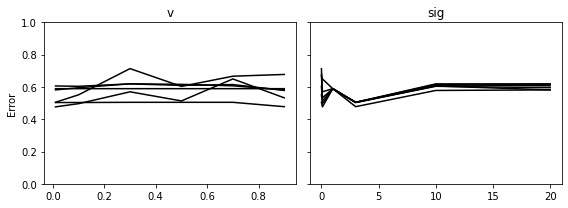

In [ ]:
# Plot
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 3))

axs[0].set_ylim([0, 1])
axs[0].set_ylabel('Error')
axs[0].set_title('v')
for i in range(6):
    axs[0].plot(v_values, err_svm[i,:], color = 'black', linestyle = '-', label = 'v')

axs[1].set_title('sig')
for i in range(6):
    axs[1].plot(sig_values, err_svm[:,i], color = 'black', linestyle = '-', label = 'sig')

plt.tight_layout()
plt.show()


In [ ]:
v = 0.1
w = vertices(5)
c = 10
k = partial(Gaussian_kernel, sigma2=1)
y_pred = hybrid(X_train, y_train, X_test, v, w, c, k)

ValueError: Incompatible dimensions (800, 3) (4, 800)

In [ ]:
within_class_error(y_test_2, y_pred)